In [1]:
import numpy as np
from array import *
import copy
import random
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from skimage import io
tf.__version__

'2.3.1'

In [2]:
dataset = pd.read_csv('skin_cancer_data1.csv', low_memory = False)
dataset_nv = pd.read_csv('skin_cancer_data2.csv', low_memory=False)

In [3]:
dataset = dataset.drop(labels='Unnamed: 0', axis=1)
dataset_nv = dataset_nv.drop(labels='Unnamed: 0', axis=1)

In [4]:
data = dataset.sample(frac = 1)

In [5]:
data['image'] = data['image'].apply(lambda x:(np.fromstring(x, dtype = int, sep = ' ')).reshape(96, 96, 3))
dataset_nv['image'] = dataset_nv['image'].apply(lambda x:(np.fromstring(x, dtype = int, sep = ' ')).reshape(96, 96, 3))

In [6]:
data_clockwise_90 = copy.copy(data)
data_clockwise_90['image'] = data_clockwise_90['image'].apply(lambda x: (cv2.rotate(x, cv2.cv2.ROTATE_90_CLOCKWISE)))

data_round_180 = copy.copy(data)
data_round_180['image'] = data_round_180['image'].apply(lambda x: (cv2.rotate(x, cv2.cv2.ROTATE_180)))

data_flip_ud = copy.copy(data)
data_flip_ud['image'] = data_flip_ud['image'].apply(lambda x: (cv2.flip(x, 0)))

data_flip_lr = copy.copy(data)
data_flip_lr['image'] = data_flip_lr['image'].apply(lambda x: (cv2.flip(x, 1)))

data_counterclockwise_90 = copy.copy(data)
data_counterclockwise_90['image'] = data_counterclockwise_90['image'].apply(lambda x: (
    cv2.rotate(x, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)))

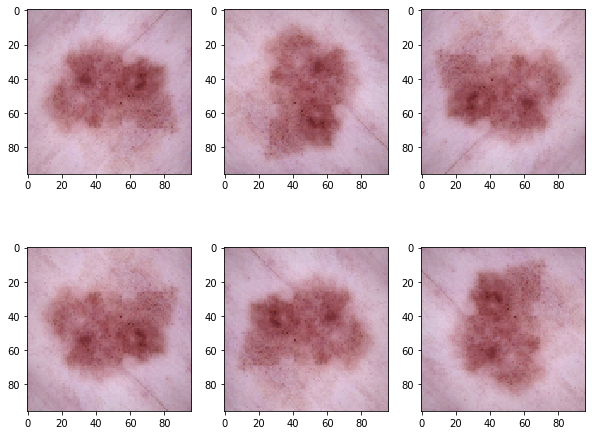

In [7]:
w_grid = 2
l_grid = 3
fig, axes = plt.subplots(w_grid, l_grid, figsize = (10, 8))
axes = axes.ravel()
j = np.random.randint(0, len(data))
axes[0].imshow(data['image'][j])
axes[1].imshow(data_clockwise_90['image'][j])
axes[2].imshow(data_round_180['image'][j])
axes[3].imshow(data_flip_ud['image'][j])
axes[4].imshow(data_flip_lr['image'][j])
axes[5].imshow(data_counterclockwise_90['image'][j])

In [8]:
data_array = data.iloc[:, :].values
data_clockwise_90_array = data_clockwise_90.iloc[:, :].values
data_round_180_array = data_round_180.iloc[:, :].values
data_flip_ud_array = data_flip_ud.iloc[:, :].values
data_flip_lr_array = data_flip_lr.iloc[:, :].values
data_counterclockwise_90_array = data_counterclockwise_90.iloc[:, :].values
dataset_nv_array = dataset_nv.iloc[:4500, :].values

In [9]:
augmented_data = np.concatenate((
    data_array, data_clockwise_90_array, data_round_180_array, data_flip_ud_array, data_flip_lr_array,
    data_counterclockwise_90_array, dataset_nv_array), axis = 0)

In [10]:
img = augmented_data[:, :-1]
y = augmented_data[:, -1]
img = img/255.0
x = np.empty((len(img), 96, 96, 3))
for i in range(len(img)):
    x[i] = img[i][0].reshape(96, 96, 3)
print(x.shape)
print(y.shape)

(24360, 96, 96, 3)
(24360,)


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(0.1/6), random_state=0, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.15, random_state=42, stratify=y_train)

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoding = OneHotEncoder()
y_train_resized = encoding.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_resized = encoding.fit_transform(y_test.reshape(-1, 1)).toarray()
y_valid_resized = encoding.fit_transform(y_valid.reshape(-1, 1)).toarray()

In [14]:
np.shape(y_train_resized), np.shape(y_test_resized), np.shape(y_valid_resized)

((20360, 7), (406, 7), (3594, 7))

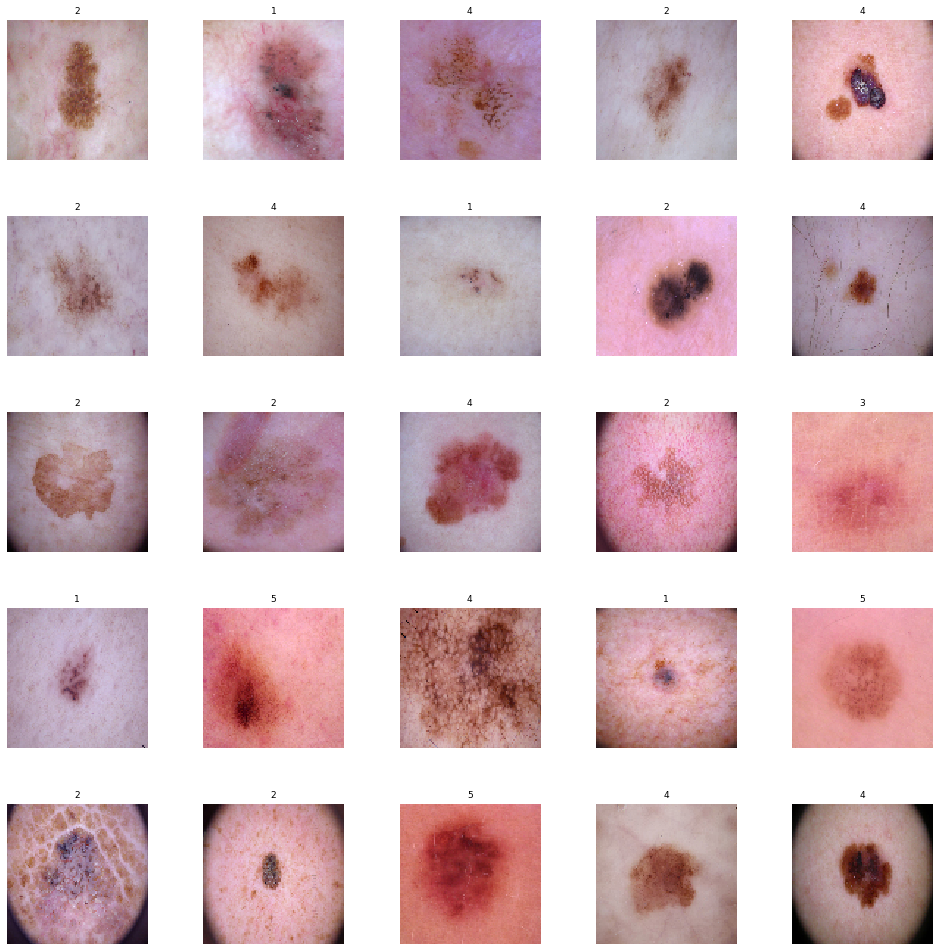

In [15]:
w_grid = 5
l_grid = 5
fig, axes = plt.subplots(w_grid, l_grid, figsize = (17, 17))
axes = axes.ravel()
for i in range(0, len(axes)):
    j = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[j].reshape(96, 96, 3))
    axes[i].set_title(y_train[j], fontsize = 9)
    axes[i].axis('off')
plt.subplots_adjust(hspace = 0.4)

In [16]:
base_model = tf.keras.applications.DenseNet169(include_top = False, input_shape = (96, 96, 3), weights = 'imagenet')

In [17]:
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block7_0_bn (BatchNormali (None, 3, 3, 832)    3328        conv5_block6_concat[0][0]        
__________________________________________________________________________________________________
conv5_block7_0_relu (Activation (None, 3, 3, 832)    0           conv5_block7_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block7_1_conv (Conv2D)    (None, 3, 3, 128)    106496      conv5_block7_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block7_1_bn (BatchNormali (None, 3, 3, 128)    512         conv5_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block7_1_relu (Activation (None, 3, 3, 128)    0           conv5_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_bloc

In [18]:
global_avarage_polling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
fully_connected_layer = tf.keras.layers.Dense(units = 1024, activation = 'relu')(global_avarage_polling)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 512, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 256, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 128, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
prediction_layer = tf.keras.layers.Dense(units = 7, activation = 'softmax')(fully_connected_layer)

In [19]:
classifier = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [20]:
classifier.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

conv5_block20_1_relu (Activatio (None, 3, 3, 128)    0           conv5_block20_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block20_2_conv (Conv2D)   (None, 3, 3, 32)     36864       conv5_block20_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block20_concat (Concatena (None, 3, 3, 1280)   0           conv5_block19_concat[0][0]       
                                                                 conv5_block20_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block21_0_bn (BatchNormal (None, 3, 3, 1280)   5120        conv5_block20_concat[0][0]       
__________________________________________________________________________________________________
conv5_block21_0_relu (Activatio (None, 3, 3, 1280)   0           conv5_block21_0_bn[0][0]         
__________

In [21]:
classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model/skin_cancer_classifier4.h5', monitor = 'val_loss', save_best_only = True,
                             mode = 'min', verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 8, mode = 'min', verbose = 1, restore_best_weights = True,
                          min_delta = 0.001)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)

callback = [earlystop, checkpoint, reduce_lr]

In [23]:
epochs_history = classifier.fit(x = x_train, y = y_train_resized, epochs = 50, verbose = 1, callbacks = callback,
                                validation_data = (x_valid, y_valid_resized))

Epoch 1/50
637/637 [==============================] - ETA: 0s - loss: 1.5543 - accuracy: 0.4099
Epoch 00001: val_loss improved from inf to 1.17934, saving model to model\skin_cancer_classifier4.h5
637/637 [==============================] - 2878s 5s/step - loss: 1.5543 - accuracy: 0.4099 - val_loss: 1.1793 - val_accuracy: 0.6372
Epoch 2/50
637/637 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.6219
Epoch 00002: val_loss improved from 1.17934 to 0.90015, saving model to model\skin_cancer_classifier4.h5
637/637 [==============================] - 2524s 4s/step - loss: 1.0741 - accuracy: 0.6219 - val_loss: 0.9001 - val_accuracy: 0.6917
Epoch 3/50
637/637 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.7204
Epoch 00003: val_loss improved from 0.90015 to 0.68440, saving model to model\skin_cancer_classifier4.h5
637/637 [==============================] - 2524s 4s/step - loss: 0.8231 - accuracy: 0.7204 - val_loss: 0.6844 - val_accuracy: 0.7627
Ep

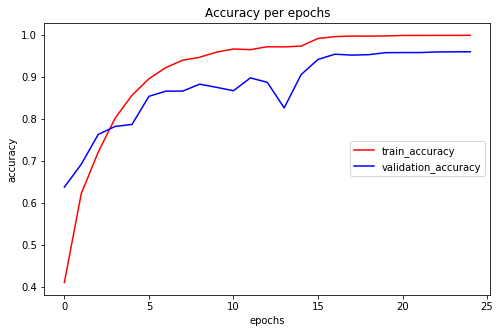

In [24]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_history.history['accuracy'], c = 'red', label="train_accuracy")
plt.plot(epochs_history.history['val_accuracy'], c = 'blue', label = 'validation_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy per epochs')
plt.legend(loc = 'center right')
plt.show()

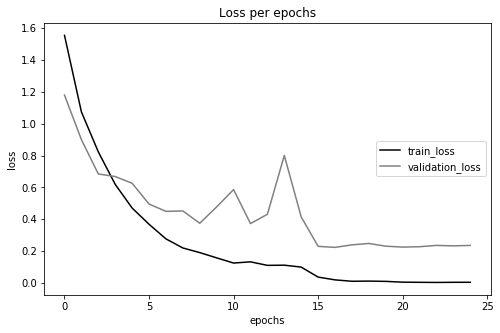

In [25]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_history.history['loss'], c = 'black', label = 'train_loss')
plt.plot(epochs_history.history['val_loss'], c = 'gray', label = 'validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss per epochs')
plt.legend(loc = 'center right')
plt.show()

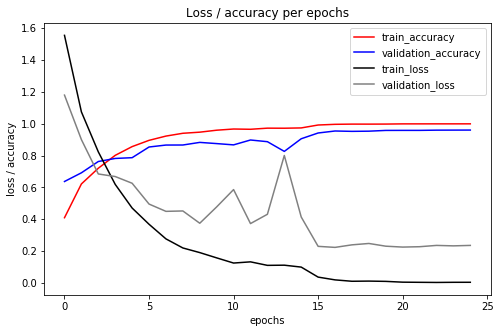

In [107]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_history.history['accuracy'], c = 'red', label="train_accuracy")
plt.plot(epochs_history.history['val_accuracy'], c = 'blue', label = 'validation_accuracy')
plt.plot(epochs_history.history['loss'], c = 'black', label = 'train_loss')
plt.plot(epochs_history.history['val_loss'], c = 'gray', label = 'validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss / accuracy')
plt.title('Loss / accuracy per epochs')
plt.legend(loc = 'upper right')
plt.show()

In [26]:
accuracy, loss = classifier.evaluate(x_test, y_test_resized)

13/13 [==============================] - 6s 445ms/step - loss: 0.2928 - accuracy: 0.9310


In [27]:
y_pred = classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

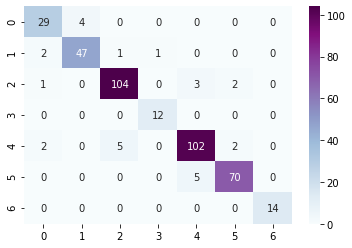

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test_resized, axis = 1), y_pred)
sns.heatmap(cm, annot=True, cmap="BuPu", fmt = 'd')

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
report = classification_report(np.argmax(y_test_resized, axis = 1), y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87        33
           1       0.92      0.92      0.92        51
           2       0.95      0.95      0.95       110
           3       0.92      1.00      0.96        12
           4       0.93      0.92      0.92       111
           5       0.95      0.93      0.94        75
           6       1.00      1.00      1.00        14

    accuracy                           0.93       406
   macro avg       0.93      0.94      0.94       406
weighted avg       0.93      0.93      0.93       406



In [30]:
accuracy_score(np.argmax(y_test_resized, axis = 1), y_pred)

0.9310344827586207

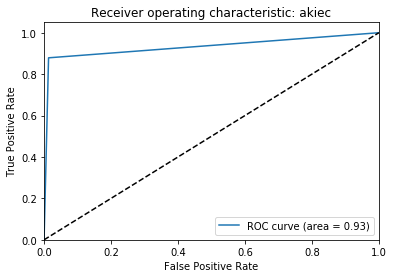

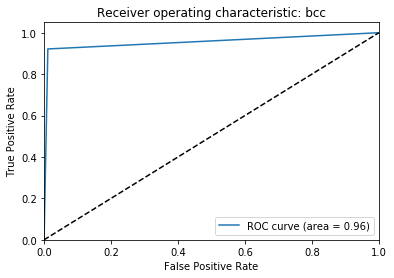

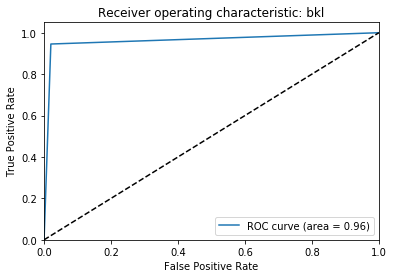

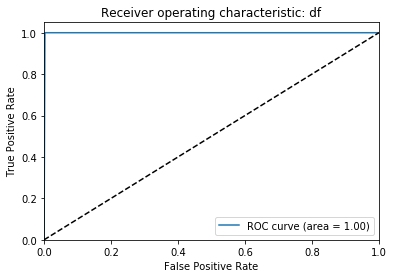

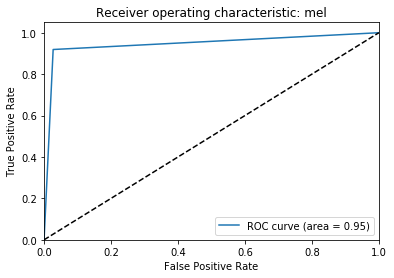

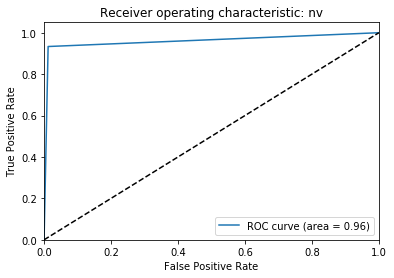

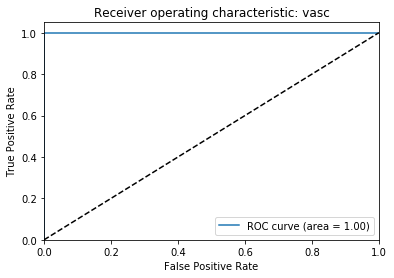

In [97]:
from sklearn.preprocessing import label_binarize
y_test1 = label_binarize((np.argmax(y_test_resized, axis = 1)), classes=[0,1,2,3,4,5,6])
y_pred11 = label_binarize(y_pred, classes=[0,1,2,3,4,5,6])
from sklearn.metrics import roc_curve, auc
disease = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred11[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ' + disease[i])
    plt.legend(loc="lower right")
plt.show()

In [98]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred11.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
from scipy import interp
from itertools import cycle
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\KIIT\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Receiver operating characteristic: DenseNet169')

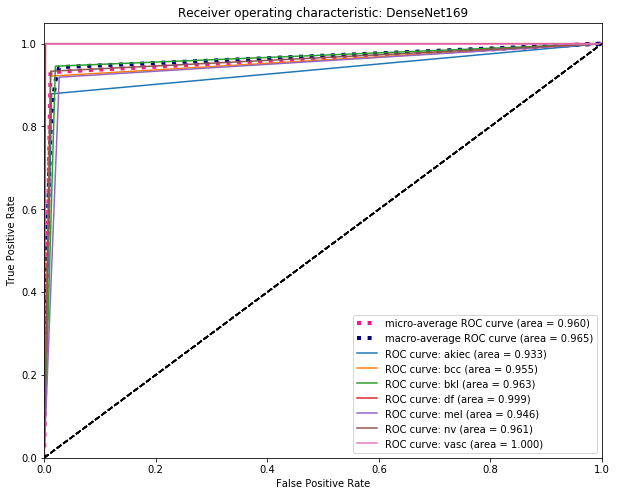

In [110]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve: '+ disease[i] + ' (area = %0.3f)' % roc_auc[i])
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic: DenseNet169')

In [64]:
base_model1 = tf.keras.applications.DenseNet121(include_top = False, input_shape = (96, 96, 3), weights = 'imagenet')
base_model1.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [66]:
global_avarage_polling = tf.keras.layers.GlobalAveragePooling2D()(base_model1.output)
fully_connected_layer = tf.keras.layers.Dense(units = 1024, activation = 'relu')(global_avarage_polling)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 512, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 512, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 256, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 128, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
prediction_layer = tf.keras.layers.Dense(units = 7, activation = 'softmax')(fully_connected_layer)
classifier1 = tf.keras.models.Model(inputs = base_model1.input, outputs = prediction_layer)
classifier1.summary()

Model: "functional_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [67]:
classifier1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])

In [68]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model/skin_cancer_classifier1.h5', monitor = 'val_loss', save_best_only = True,
                             mode = 'min', verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 8, mode = 'min', verbose = 1, restore_best_weights = True,
                          min_delta = 0.001)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)

callback = [earlystop, checkpoint, reduce_lr]

In [69]:
epochs_history1 = classifier1.fit(x = x_train, y = y_train_resized, epochs = 50, verbose = 1, callbacks = callback,
                                validation_data = (x_valid, y_valid_resized))

Epoch 1/50
637/637 [==============================] - ETA: 0s - loss: 1.8489 - accuracy: 0.2722
Epoch 00001: val_loss improved from inf to 1.49945, saving model to model\skin_cancer_classifier1.h5
637/637 [==============================] - 2310s 4s/step - loss: 1.8489 - accuracy: 0.2722 - val_loss: 1.4994 - val_accuracy: 0.4393
Epoch 2/50
637/637 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.4508
Epoch 00002: val_loss improved from 1.49945 to 1.13176, saving model to model\skin_cancer_classifier1.h5
637/637 [==============================] - 2289s 4s/step - loss: 1.3394 - accuracy: 0.4508 - val_loss: 1.1318 - val_accuracy: 0.6038
Epoch 3/50
637/637 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.5807
Epoch 00003: val_loss improved from 1.13176 to 0.96993, saving model to model\skin_cancer_classifier1.h5
637/637 [==============================] - 2239s 4s/step - loss: 1.1213 - accuracy: 0.5807 - val_loss: 0.9699 - val_accuracy: 0.6753
Ep

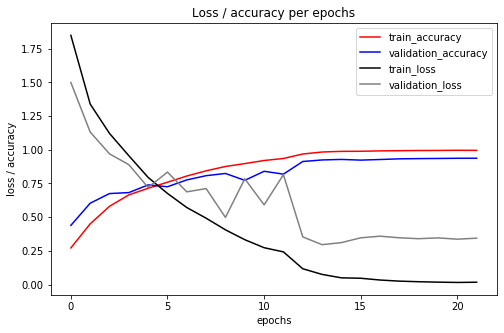

In [108]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_history1.history['accuracy'], c = 'red', label="train_accuracy")
plt.plot(epochs_history1.history['val_accuracy'], c = 'blue', label = 'validation_accuracy')
plt.plot(epochs_history1.history['loss'], c = 'black', label = 'train_loss')
plt.plot(epochs_history1.history['val_loss'], c = 'gray', label = 'validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss / accuracy')
plt.title('Loss / accuracy per epochs')
plt.legend(loc = 'upper right')
plt.show()

In [70]:
accuracy1, loss1 = classifier1.evaluate(x_test, y_test_resized)

13/13 [==============================] - 5s 370ms/step - loss: 0.3406 - accuracy: 0.9113


In [118]:
accuracy1, loss1 = classifier1.evaluate(x_test, y_test_resized)

13/13 [==============================] - 8s 619ms/step - loss: 0.3406 - accuracy: 0.9113


In [119]:
y_pred1 = classifier1.predict(x_test)
y_pred1 = np.argmax(y_pred1, axis = -1)

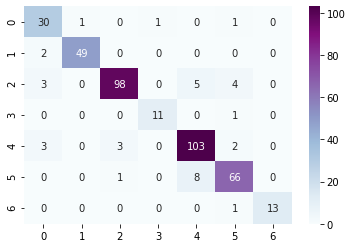

In [120]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(np.argmax(y_test_resized, axis = 1), y_pred1)
sns.heatmap(cm1, annot=True, cmap="BuPu", fmt = 'd')

In [121]:
from sklearn.metrics import classification_report, confusion_matrix
report1 = classification_report(np.argmax(y_test_resized, axis = 1), y_pred1)
print(report1)

              precision    recall  f1-score   support

           0       0.79      0.91      0.85        33
           1       0.98      0.96      0.97        51
           2       0.96      0.89      0.92       110
           3       0.92      0.92      0.92        12
           4       0.89      0.93      0.91       111
           5       0.88      0.88      0.88        75
           6       1.00      0.93      0.96        14

    accuracy                           0.91       406
   macro avg       0.92      0.92      0.92       406
weighted avg       0.91      0.91      0.91       406



In [122]:
accuracy_score(np.argmax(y_test_resized, axis = 1), y_pred1)

0.9113300492610837

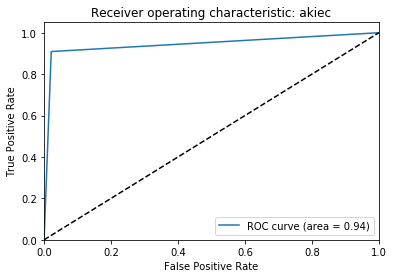

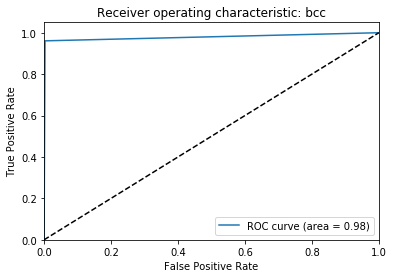

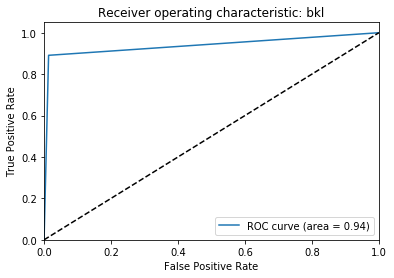

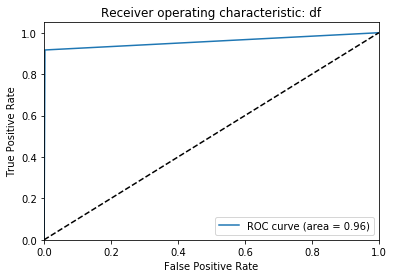

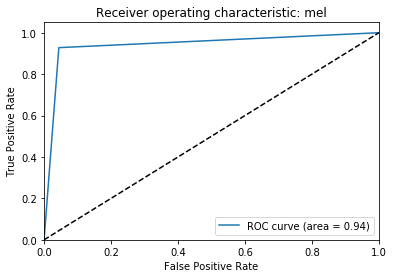

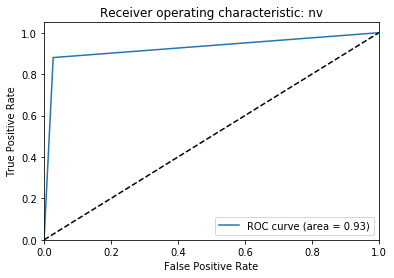

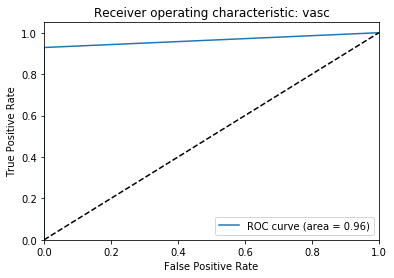

In [123]:
from sklearn.preprocessing import label_binarize
y_test1 = label_binarize((np.argmax(y_test_resized, axis = 1)), classes=[0,1,2,3,4,5,6])
y_pred111 = label_binarize(y_pred1, classes=[0,1,2,3,4,5,6])
from sklearn.metrics import roc_curve, auc
disease = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred111[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ' + disease[i])
    plt.legend(loc="lower right")
plt.show()

In [124]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred111.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
from scipy import interp
from itertools import cycle
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\KIIT\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Receiver operating characteristic: DenseNet121')

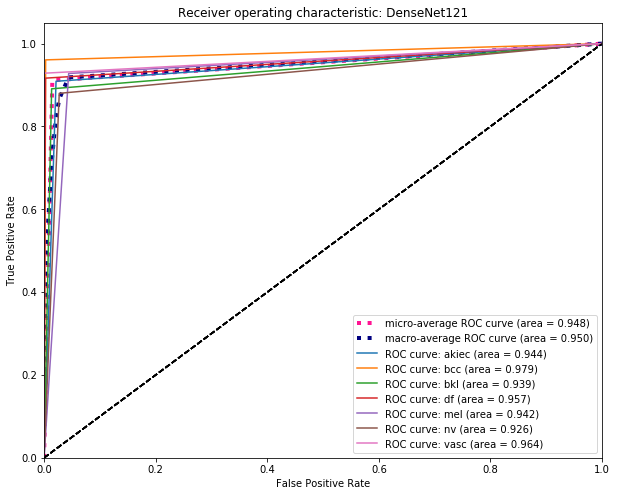

In [125]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve: '+ disease[i] + ' (area = %0.3f)' % roc_auc[i])
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic: DenseNet121')

In [85]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _= roc_curve(y_test1[:, i], y_pred111[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred111.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\Users\KIIT\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


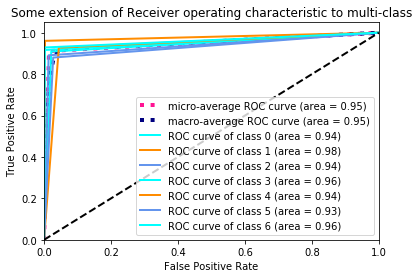

In [89]:
from scipy import interp
from itertools import cycle
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()